In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Thesis/Comparison study/Utils')
import data_utils as data
import metric_utils as mtric
import utils

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import concatenate
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPooling1D, Embedding, Reshape
from keras.models import Model, load_model
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate

# from keras.backend.tensorflow_backend import set_session

import nltk
nltk.download('stopwords')

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import re
import gc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# gpu = tf.config.experimental.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(gpu, True)

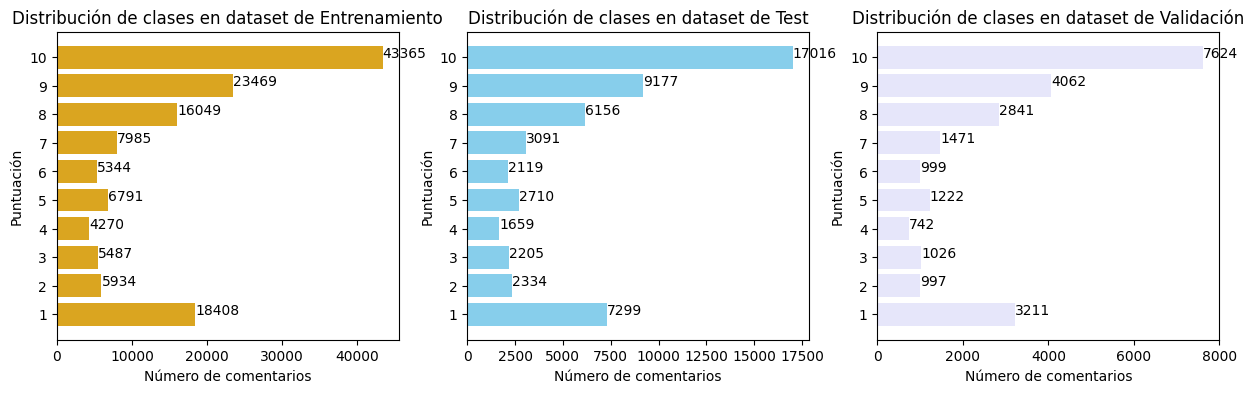

In [ ]:
#%time data_x, data_y = load_data('dataset/Raw/Train.tsv', [1, 3, 4], True, 1)
MAX_NB_WORDS = 30000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 250

path_train = '/content/gdrive/MyDrive/Thesis/Comparison study/dataset/Processed/Train_coma_blind_num.pickle'
path_test = '/content/gdrive/MyDrive/Thesis/Comparison study/dataset/Processed/Test_coma_blind_num.pickle'
#path_w2v = 'w2v/Set9_TweetDataWithSpam_GeneralData_Word.bin' # http://evexdb.org/pmresources/vec-space-models/

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
dataset = data.Dataset()

dataset.load_pickle(path_train, path_test, label_name='rating')
#model = KeyedVectors.load_word2vec_format(path_w2v, binary=True)
#MAX_SEQUENCE_LENGTH = dataset.text_len_distribution(col_name='review', plot=False)[0]
tokenizer.fit_on_texts([x for x in list(dataset.get_train_x().review)+list(dataset.get_test_x().review)])
dataset.make_dev_split(dev_split=0.15)
dataset.classes_distribution()

In [ ]:
# dataset.replace(parse_col_name='review', old='#', new='$number')

In [ ]:
# tokenizer.fit_on_texts([x for x in list(dataset.get_train_x().review)+list(dataset.get_test_x().review)])
# dataset.make_dev_split(dev_split=0.15)
# dataset.classes_distribution()

In [ ]:
sequences_train = tokenizer.texts_to_sequences(dataset.get_train_x().review)
sequences_dev = tokenizer.texts_to_sequences(dataset.get_dev_x().review)
sequences_test = tokenizer.texts_to_sequences(dataset.get_test_x().review)

Xtrain = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xdev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xtest = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
ytrain = to_categorical(dataset.get_train_y()-dataset.get_train_y().min())
ydev = to_categorical(dataset.get_dev_y()-dataset.get_dev_y().min())
ytest = to_categorical(dataset.get_test_y()-dataset.get_test_y().min())

del sequences_dev, sequences_train, sequences_test
gc.collect()

0

In [ ]:
word_index = tokenizer.word_index
num_words = min(MAX_NB_WORDS, len(word_index))
# embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype=np.float32)
# count = 0
# for word, i in word_index.items():
#     if i >= num_words:
#         continue
#     if word in model:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = model[word]
#         count = count+1
# print (count," ",num_words)

In [ ]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(df_train.label)), np.asarray(df_train.label))
# class_weight_dict = dict(enumerate(class_W))

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).argmax(axis=1)
        targ = self.validation_data[1].argmax(axis=1)
        #f1 = f1_score(targ, predict, average='micro')
        mtrcs = precision_recall_fscore_support(targ, predict, average='macro')
        print ("\nPrecision: "+str(mtrcs[0])+"\tRecall: "+str(mtrcs[1])+"\tF1: "+str(mtrcs[2]))
        if (self.f1s < mtrcs[2]):
            self.f1s = mtrcs[2]
            self.model.save('./model/LSTM_CNN_Random_Best_EMRS_model_f1_.hdf5')
            print("Modelo guardado\n")
        return

metrics = Metrics()

In [ ]:
# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(dataset.get_train_y())), np.asarray(dataset.get_train_y()))
# class_weight_dict = dict(enumerate(class_W))

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)

biLSTM_1 = Bidirectional(LSTM(250, return_sequences=True))(drop_out_1)

conv_1 = Conv1D(64, 2, activation='relu', name='conv_1')(biLSTM_1)
gmp_1 = GlobalMaxPooling1D(name='gmp_1')(conv_1)
conv_2 = Conv1D(64, 3, activation='relu', name='conv_2')(biLSTM_1)
gmp_2 = GlobalMaxPooling1D(name='gmp_2')(conv_2)
conv_3 = Conv1D(64, 5, activation='relu', name='conv_3')(biLSTM_1)
gmp_3 = GlobalMaxPooling1D(name='gmp_3')(conv_3)

concat = Concatenate()([gmp_1,gmp_2,gmp_3])
drop_out_2 = Dropout(0.3, name='drop_out_2')(concat)
mp_dense = Dense(128, activation='relu', name='mp_dense')(drop_out_2)
preds = Dense(10, activation='softmax', name='preds')(mp_dense)
LSTM_CNN_model = Model(sequence_input, preds)

LSTM_CNN_model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

callbacks_list = [metrics]

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def on_test_end(self, logs=None):
        val_predict = np.asarray(self.model.predict(Xdev)).argmax(axis=1)
        val_targ = ydev.argmax(axis=1)
        # calculate and print f1_score, precision, recall, or any other metric you're interested in.


In [ ]:
#200 epochs -> start at 13:35 - ends at XX:XX
LSTM_CNN_model.fit(Xtrain, ytrain,
      shuffle=True,
      batch_size=200,
      epochs=200,
      callbacks=[CustomCallback()],
      validation_data=(Xdev, ydev))


Epoch 1/200
686/686 [==============================] - 110s 137ms/step - loss: 1.6453 - accuracy: 0.4149 - val_loss: 1.5258 - val_accuracy: 0.4453
Epoch 2/200
686/686 [==============================] - 51s 75ms/step - loss: 1.4463 - accuracy: 0.4661 - val_loss: 1.4658 - val_accuracy: 0.4579
Epoch 3/200
686/686 [==============================] - 45s 66ms/step - loss: 1.3384 - accuracy: 0.4974 - val_loss: 1.4625 - val_accuracy: 0.4657
Epoch 4/200
686/686 [==============================] - 43s 62ms/step - loss: 1.2352 - accuracy: 0.5326 - val_loss: 1.4391 - val_accuracy: 0.4798
Epoch 5/200
686/686 [==============================] - 42s 61ms/step - loss: 1.1370 - accuracy: 0.5664 - val_loss: 1.4286 - val_accuracy: 0.5014
Epoch 6/200
686/686 [==============================] - 42s 62ms/step - loss: 1.0420 - accuracy: 0.6014 - val_loss: 1.4633 - val_accuracy: 0.5142
Epoch 7/200
686/686 [==============================] - 41s 60ms/step - loss: 0.9530 - accuracy: 0.6357 - val_loss: 1.5182 - val_

In [ ]:
# LSTM_CNN_Best_model = load_model('/model/LSTM_CNN_Random_Best_EMRS_model_f1_.hdf5')
y_test = ytest.argmax(axis=1)

In [ ]:
# result = Best_model.predict(Xtest).argmax(axis=1)
result = LSTM_CNN_model.predict(Xtest).argmax(axis=-1)
print(classification_report(y_test, result, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

In [ ]:
result2 = LSTM_CNN_Best_model.predict(Xtest).argmax(axis=1)
print(classification_report(y_test, result2, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

In [ ]:
data.matrix_printer(confusion_matrix(y_test, result2), [1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]).show()

In [ ]:
LSTM_CNN_model.save('./model/LSTM_CNN_Random_200epoch_EMRS_model_f1_.hdf5')

In [ ]:
from IPython.display import display, Javascript
display(Javascript('google.colab.kernel.disconnect();'))


<IPython.core.display.Javascript object>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5ac3449-1655-4cd7-abfe-a81c6ac2b5f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>